In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
sys.path.insert(0,'/nfs/guille/afern/users/shrestaa/')

In [3]:
from monodac.rl_core.buffer import StandardBuffer
from monodac.custom_environments.frozen_lake import FrozenLakeEnv, save_and_print_results
from monodac.legacy.MDP_GPU_FACTORED import FullMDPFactored
import argparse
import os 
from munch import Munch 
import itertools
from tqdm.notebook import tqdm

In [4]:
config = Munch({})

config.envArgs = Munch({})
config.envArgs.env_name = "frozen_lake"
config.envArgs.map_size = 15

config.logArgs = Munch({})
config.logArgs.exp_id = f"Map{config.envArgs.map_size}"
config.logArgs.results_dir = f"results/{config.envArgs.env_name}-{config.logArgs.exp_id}/"

config.dataArgs = Munch({})
config.dataArgs.buffer_size = 100000
config.dataArgs.buffer_device = "cpu"

config.mdpBuildArgs = Munch({})
config.mdpBuildArgs.ur = -1000
config.mdpBuildArgs.MAX_S_COUNT = config.envArgs.map_size**2 + 10
config.mdpBuildArgs.MAX_NS_COUNT = 10

config.mdpSolveArgs = Munch({})
config.mdpSolveArgs.gamma = 0.99
config.mdpSolveArgs.slip_prob = 0.1
config.mdpSolveArgs.default_mode = "GPU"


In [5]:
print(config)
os.makedirs(config.logArgs.results_dir, exist_ok = True)
env = FrozenLakeEnv((config.envArgs.map_size, config.envArgs.map_size))

Munch({'envArgs': Munch({'env_name': 'frozen_lake', 'map_size': 15}), 'logArgs': Munch({'exp_id': 'Map15', 'results_dir': 'results/frozen_lake-Map15/'}), 'dataArgs': Munch({'buffer_size': 100000, 'buffer_device': 'cpu'}), 'mdpBuildArgs': Munch({'ur': -1000, 'MAX_S_COUNT': 235, 'MAX_NS_COUNT': 10}), 'mdpSolveArgs': Munch({'gamma': 0.99, 'slip_prob': 0.1, 'default_mode': 'GPU'})})


In [6]:
train_buffer =  StandardBuffer(state_shape = env.reset().shape,
                               action_shape = env.reset().shape, 
                               buffer_size = config.dataArgs.buffer_size,
                               device = config.dataArgs.buffer_device)
env._max_episode_steps = config.envArgs.map_size**2

In [7]:
env.GetStateSpace()

226

In [8]:
# Collect random Dataset # till replay initial\
random_policy = lambda s: env.sample_random_action()
train_buffer, info = StandardBuffer.populate_buffer(train_buffer, env, episode_count=9999, render=False, policy=random_policy,
                                           frame_count=config.dataArgs.buffer_size, pad_attribute_fxn={"qval": lambda s: 0})

Average Reward of collected trajectories:-86.646


# Traditional MDP

In [9]:
A = list(set([a for s,a,ns,r,d in train_buffer.get_tran_tuples()]))
mdp_T = FullMDPFactored(A = A,
                    build_args=config.mdpBuildArgs, 
                    solve_args=config.mdpSolveArgs)

In [10]:
# len([1 for tran_tuple in  train_buffer.get_tran_tuples() if tran_tuple[-1] ])
for t in  tqdm(train_buffer.get_tran_tuples()): 
    s, a, ns, r, d = t
    tc =  (s, a, ns, (r, 0), d)
    mdp_T.consume_transition(tc)
        

  0%|          | 0/100000 [00:00<?, ?it/s]

In [11]:
mdp_T.curr_vi_error = 999

In [12]:
mdp_T.solve(1e-1,safe_bkp=True,mode="GPU")

Elapsed Time:1s, VI Error:0.0, #Backups: 250
Time takedn to solve 1.0286056995391846


In [22]:
val_vector = [-1000]*env.GetStateSpace()
pi_vector = [0]*env.GetStateSpace()
for i in tqdm(list(range(env.GetStateSpace()))):
    s = (i,)
    if s in mdp_T.valueDict:
        val_vector[i] = mdp_T.valueDict[s]
        pi_vector[i] = int(mdp_T.polDict[s][0])

  0%|          | 0/226 [00:00<?, ?it/s]

In [23]:
# pi_vector

In [16]:
from monodac.rl_core.utils_eval import evaluate_on_env

policy_func = lambda s : int(mdp_T.s_polDict[tuple(s)][0])
# policy_func = lambda s : pi_vector[s[0]]
avg_reward, info =  evaluate_on_env(env, policy_func, eps_count=50, eval_eps=0, progress_bar=True)
print("Average Reward", avg_reward)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 83.59it/s]

Average Reward 562.62


In [17]:
# config.logArgs.results_dir

In [18]:
config.mdpBuildArgs.MAX_S_COUNT 

235

In [20]:
# save_and_print_results(val_vector, pi_vector, MAP=env.map_grid, env=env, beta=0.99, 
#                        name="cpu", results_dir=config.logArgs.results_dir)

In [21]:
# save_and_print_results(val_vector, pi_vector, MAP=env.map_grid, env=env, beta=0.99, 
#                        name="cpu", results_dir=config.logArgs.results_dir)

# Pytorch VI

In [22]:
from monodac.rl_core.vi_solver import MDP, MDPBuild

In [23]:
# space_vectors[0]

In [24]:
space_vectors, core_vectors, sec_vectors = MDPBuild.get_empirical_mdp_params_from_transitions(train_buffer.get_tran_tuples())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:16<00:00, 6149.12it/s]


In [25]:
mdp = MDP(space_vectors, core_vectors)

In [26]:
mdp.solve(0.00001)

0 tensor(999.9990, device='cuda:0')
Solved MDP in 128 Backups
Function 'solve' executed in 0.3435s


In [27]:
mdp.curr_error

tensor(0., device='cuda:0')

In [28]:
from monodac.rl_core.utils_eval import evaluate_on_env

# policy_func = lambda s : int(mdp_T.s_polDict[tuple(s)][0])
policy_func = lambda s : mdp.policy(s).cpu().numpy()
avg_reward, info =  evaluate_on_env(env, policy_func, eps_count=50, eval_eps=0, progress_bar=True)
print("Average Reward", avg_reward)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.17it/s]

Average Reward 646.74


In [33]:
val_vector = [-1000]*env.GetStateSpace()
pi_vector = [0]*env.GetStateSpace()
for i in tqdm(list(range(env.GetStateSpace()))):
    s = (i,)
    if s in mdp_T.valueDict:
        val_vector[i] = mdp.V[i+1].cpu()
        pi_vector[i] = mdp.Pi[i+1].cpu()

  0%|          | 0/226 [00:00<?, ?it/s]


Average reward: 437.9

Avereage discounted reward: 629.7946715945704

State Value image view:



Best Q-value and Policy:



(437.9, 629.7946715945704)

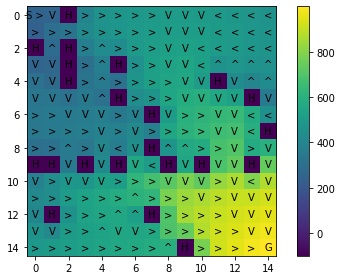

In [34]:
save_and_print_results(val_vector, pi_vector, MAP=env.map_grid, env=env, beta=0.99, 
                       name="cpu", results_dir=config.logArgs.results_dir)